In [299]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [3]:
metaDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEn.csv", lineterminator="\n")

entDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podIntroductions/floydMonth500wordNEs.csv", names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

descEntDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podDescriptions/floydMonthNEs.tsv", sep="\t",
                        names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

introDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/floydIntroductions.tsv", sep="\t", names=["potentialOutPath", "first500"]) 

transcriptDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/allTranscripts.tsv", sep="\t", names=["potentialOutPath", "transcript"], lineterminator="\n")


In [ ]:
"""
random info
we have 828 gb of data in transcripts + prosodic information right now
"""

## Clean Each Dataframe

In [226]:
transcriptDf.shape

(601207, 2)

In [244]:
transDups = transcriptDf[transcriptDf.duplicated(subset=["potentialOutPath"], keep=False)]

In [247]:
"""
out of the 601,207 transcripts, 18,124 of the paths are duplicates.
(that's 3.01%), but only half of those get dropped 

not exactly sure where these come from is the thing... 
"""

"\nout of the 601,207 transcripts, 18,124 of the paths are duplicates.\n(that's 1.6%) \n\n\n"

In [263]:
#this shows that they're all exact duplicates on both the outpath and the transcript
print(transDups[transDups.duplicated(keep=False)].sort_values("potentialOutPath").shape)
print(transDups.shape)

In [ ]:
scriptDups = transcriptDf[transcriptDf.duplicated(subset=["transcript"], keep=False)]

scriptDups.shape

In [ ]:
"""
Duplicated transcripts.. 
we have 53,211 transcripts that are duplicates, which is 8.85%
we only need to remove half of these which gives 4.425% that are removed \

about one third of the duplicates are very short 

from qualitative review of dups we are getting some amount of music-only and blank audio, which could have something
to do with this problem 

i.e. "content [silence]" or "content [music]" 
"""

In [272]:
#what is the length of these duplicate transcripts 
scriptDups["scriptLen"] = scriptDups["transcript"].apply(lambda x: len(x.split()))

<ipython-input-272-bdae48c04eee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scriptDups["scriptLen"] = scriptDups["transcript"].apply(lambda x: len(x.split()))


In [277]:
53211 / 601207

0.08850695351185199

(53211, 3)


<Axes: xlabel='scriptLen', ylabel='Proportion'>

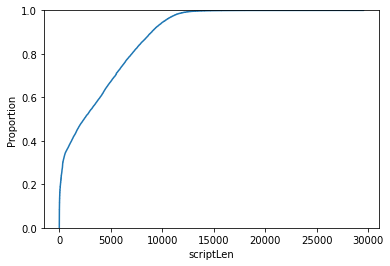

In [275]:
print(scriptDups.shape)
sns.ecdfplot(data=scriptDups, x="scriptLen")

In [284]:
#scriptDups.sort_values("transcript").reset_index(drop=True).iloc[0:10]

In [282]:
#scriptDups.sample(20)

In [12]:
metaDf.columns

Index(['Unnamed: 0', 'rssUrl', 'epTitle', 'epDescription', 'duration',
       'pubDate', 'copyright', 'itunes:type', 'itunes:complete', 'guid',
       'itunes:explicit', 'enclosure', 'itunes:image', 'transDict', 'id',
       'title', 'lastUpdate', 'link', 'lastHttpStatus', 'dead', 'contentType',
       'itunesId', 'originalUrl', 'itunesAuthor', 'itunesOwnerName',
       'explicit', 'imageUrl', 'itunesType', 'generator', 'newestItemPubdate',
       'language', 'oldestItemPubdate', 'episodeCount', 'popularityScore',
       'priority', 'createdOn', 'updateFrequency', 'chash', 'host',
       'newestEnclosureUrl', 'podcastGuid', 'podDescription', 'category1',
       'category2', 'category3', 'category4', 'category5', 'category6',
       'category7', 'category8', 'category9', 'category10',
       'newestEnclosureDuration', 'oldestItemDatetime', 'cleanDates',
       'potentialOutPath', 'cleanDatesLoc'],
      dtype='object')

In [285]:
#drop duplicates in transcript df
#note that this removes duplicates on the (outPath, transcript) columns
#which ones we keep doesn't matter because they're perfect duplicates of eachother
transcriptDf = transcriptDf.drop_duplicates(keep="first")

In [291]:
#do we have any NaN or None values in the transcripts or outPaths? 
#only one row!? 
#and no NaN values for potentialOutPath
print(transcriptDf[transcriptDf["transcript"].isna()].shape)
print(transcriptDf[transcriptDf["potentialOutPath"].isna()].shape) 

#no "None" values 
transcriptDf[transcriptDf["transcript"] == None]
transcriptDf[transcriptDf["potentialOutPath"] == None]

#drop the na's (one row atm) 
transcriptDf = transcriptDf.dropna()

In [296]:
#are there transcripts that are too short? 
transcriptDf["wCount"] = transcriptDf["transcript"].apply(lambda x: len(x.split()))

In [302]:
print(f'average word count: {np.mean(transcriptDf["wCount"])}') 
print(f'median word count: {np.median(transcriptDf["wCount"])}') 
print(f'total word count: {sum(transcriptDf["wCount"])}')

average word count: 4204.260490577457
median word count: 3673.0
total word count: 2486849510


In [311]:
#do we have transcripts that have no real content?
#we had about 5,800 transcripts with word counts under or equal to 10
print(transcriptDf[transcriptDf["wCount"] > 10].shape)
transcriptDf = transcriptDf[transcriptDf["wCount"] > 10]

(586225, 3)


In [328]:
#duplicates on potentialOutPath in metadata
print(metaDf[metaDf.duplicated(subset=["potentialOutPath"], keep=False)].shape) 

(0, 57)


In [357]:
#drop duplicates on potential out path 
metaDf = metaDf.drop_duplicates(subset=["potentialOutPath"], keep="first")

In [331]:
#for parsing the metadata durations 
def parseDurations(inDuration): 
    #if na value, just return na value 
    if inDuration != inDuration: 
        return inDuration 
    
    inDuration = str(inDuration)
    inDuration = re.sub("[A-z]", "", inDuration)
    colonCount = inDuration.count(":")
    
    try: 
        
        #parse different strings into number of seconds 
        if colonCount == 0: 
            return int(inDuration)

        elif colonCount == 1: 
            mins, seconds = [int(item) for item in inDuration.split(":")]
            return (60*mins) + seconds 

        elif colonCount == 2: 
            hours, mins, seconds = [int(item) for item in inDuration.split(":")]
            return (hours*60*60) + (mins*60) + seconds
        else: 
            return np.nan
    except: 
        return np.nan

In [ ]:
""" 
We have a very small (like 300) number of podcasts that are over 10 hours. 
No discernable reason why, so we must assume a data entry error... 
"""

In [332]:
#now parse durations
metaDf["parsedDuration"] = metaDf["duration"].apply(parseDurations) 

In [335]:
#2% of the values parsed are na 
np.mean(metaDf["parsedDuration"].isna()) 

0.02080318684904721

In [343]:
metaDf["hours"] = metaDf["parsedDuration"] / (60 * 60) 

In [348]:
longPods = metaDf.loc[metaDf["hours"] > 10]
longPods[["duration", "parsedDuration"]]

,duration,parsedDuration
6939,93480,93480.0
6940,40080,40080.0
6941,91920,91920.0
6942,55500,55500.0
13020,115800,115800.0
...,...,...
769765,120900,120900.0
784602,525013,525013.0
784603,486971,486971.0
784604,412311,412311.0


In [351]:
#longPods[["epTitle"]]

Text(0.5, 1.0, '(all) podcast durations ecdf')

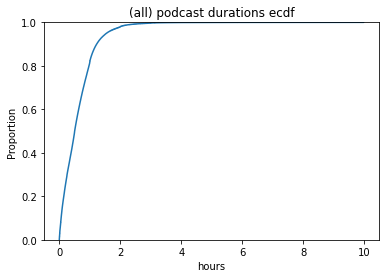

In [347]:
sns.ecdfplot(data=metaDf[metaDf["hours"] < (10)], x="hours")
plt.title("(all) podcast durations ecdf")

In [377]:
metaDf.shape

(769161, 59)

In [119]:
#metaDf["potentialOutPath"] = "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth" + metaDf["potentialOutPath"]

In [378]:
transcriptDf.shape

(586225, 3)

In [359]:
df = pd.merge(transcriptDf, metaDf, on="potentialOutPath", how="left") 

df.shape

In [374]:
"""
sampling entDf and descEntDf, they both seem fine... 
we do get duplicates though, which is odd. I assume this comes from 
reading the same file twice when running NER? didn't drop duplicates before doing NER potentially?

entDf dups -> 150,000
desEntDf dups -> 40,000 
(both are tiny fractions of all entities extracted) 
"""
sum(entDf.duplicated()) 
sum(descEntDf.duplicated())

entDf = entDf.drop_duplicates() 
descEntDf = descEntDf.drop_duplicates() 

In [379]:
#add the entities in, but first check on duplicates 
entDf = entDf.groupby(by="potentialOutPath").agg(list)

In [380]:
entDf = entDf.reset_index() 

In [381]:
df = pd.merge(df, entDf, on="potentialOutPath", how="left") 

In [382]:
descEntDf = descEntDf.groupby(by="potentialOutPath").agg(list)

In [383]:
descEntDf = descEntDf.reset_index() 

In [384]:
descEntDf["potentialOutPath"] = "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth" + descEntDf["potentialOutPath"]

In [388]:
#check for duplicates on the indices of descEntDf and entDf
#all good!
sum(entDf["potentialOutPath"].duplicated())
sum(descEntDf["potentialOutPath"].duplicated())

0

In [389]:
df = df.rename(columns={"ent":"500ent", "start":"500start", "end":"500end", "type":"500type"})

In [390]:
df = df.drop(columns=['Unnamed: 0']) 

In [391]:
df = pd.merge(df, descEntDf, on="potentialOutPath", how="left") 

In [392]:
df = df.rename(columns={"ent":"DescEnt", "start":"DescStart", "end":"DescEnd", "type":"DescType"})

In [393]:
#validating that we have as many rows in our dataframe as we do transcripts that we've processed 
df.shape

(586225, 68)

In [ ]:
"""
We have some duplicates on the outPaths and these are not all identical in terms of
the (outPath, transcript) pair 
"""

In [408]:
#get David's stuff 
print(sum(df.dropna(subset=["hours"])["hours"]))
print(np.mean(df.dropna(subset=["hours"])["hours"]))
print(np.median(df.dropna(subset=["hours"])["hours"]))

259438.1211111099
0.442582914290924
0.41583333333333333


In [418]:
min(df["cleanDates"]) 

'2020-05-11 00:00:00'

In [419]:
max(df["cleanDates"]) 

'2020-06-08 00:00:00+11:00'

In [415]:
259438 * 60

15566280

In [414]:
#number of episodes 
len(df["rssUrl"].unique())

187119

In [422]:
df.shape

(586225, 68)

Text(0.5, 1.0, 'ecdf: duration of collected podcasts')

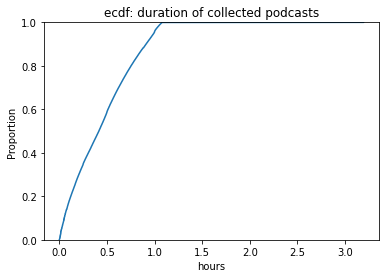

In [424]:
sns.ecdfplot(data=df, x="hours")
plt.title("ecdf: duration of collected podcasts") 

In [428]:
#now merge in the first 500 words that we got the entities from 
introDups = introDf[introDf.duplicated(subset=["potentialOutPath"], keep=False)]

In [429]:
print(introDups.shape) 
print(sum(introDups.duplicated())) 

(15600, 2)
8288


In [431]:
#introDups.sort_values("first500")

,potentialOutPath,first500
529161,/shared/3/projects/benlitterer/podcastData/pro...,"content #HANISW Well"" it's unbelievable that w..."
113347,/shared/3/projects/benlitterer/podcastData/pro...,"content #HANISW Well"" it's unbelievable that w..."
528058,/shared/3/projects/benlitterer/podcastData/pro...,"content #HANISW Well"" it's unbelievable that w..."
528048,/shared/3/projects/benlitterer/podcastData/pro...,content #HANISW. #HANISW. #HANISW. #HANISW. #H...
113337,/shared/3/projects/benlitterer/podcastData/pro...,content #HANISW. #HANISW. #HANISW. #HANISW. #H...
...,...,...
72867,/shared/3/projects/benlitterer/podcastData/pro...,"content"" """"""Sailatsut but katsut"""""""""" """"""Vane ..."
371979,/shared/3/projects/benlitterer/podcastData/pro...,"content"" """"""Sleak"" you've got to get that key""..."
273389,/shared/3/projects/benlitterer/podcastData/pro...,"content"" """"""Sleak"" you've got to get that key""..."
126719,/shared/3/projects/benlitterer/podcastData/pro...,"content"" """"""Tara Baba Shaka Rabu Sian Tara Bab..."


In [432]:
introDf = introDf.drop_duplicates(subset=["potentialOutPath"]) 

In [433]:
df = pd.merge(df, introDf, on ="potentialOutPath", how="left") 

In [394]:
def cleanQuotes(inStr): 
    if inStr != inStr: 
        return inStr 
    outStr = re.sub('(?<!")"(?!")', ',',inStr) 
    return re.sub('"""', '"', outStr)

In [395]:
from tqdm import tqdm

In [396]:
outList = []
for i, row in tqdm(df.iterrows()): 
    outList.append(cleanQuotes(row["transcript"])[8:])

16218it [00:21, 743.48it/s]


KeyboardInterrupt: 

In [200]:
df["transcript"] = outList

KeyboardInterrupt: 

In [222]:
df.to_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthData.jsonl", orient="records", lines=True)